Baseline using ConvLSTM + OpenPose

In [1]:
# Use output of OpenPose with or without background
BACKGROUND = False
# frame_diff for diff across channels, frame_dist for merging differences in 1 channel
FRAME_FUNC = 'frame_diff_dist_combined'
# To use frame diff to weight t (current) or t+1
WEIGHT_CURRENT = True
# Paths to videos for training
PATHS = ["../input/tfginfo-rwf2000/RWF-2000", f"../input/tfginfo-openpose-output/openpose_output/openpose_{'' if BACKGROUND else 'no_'}back"]

In [2]:
import tensorflow as tf

Set seed

In [3]:
SEED = 0
import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load data

In [4]:
import numpy as np
import cv2

In [5]:
ORIGINAL_FRAMES_PER_VIDEO = 150
FRAMES_PER_VIDEO = 50 + 1
VIDEO_WIDTH, VIDEO_HEIGHT = 100, 100
N_CHANNELS = 3
NORM_WIDTH, NORM_HEIGHT = 5, 5


def load_videos(video_IDs: list, video_frames: int = FRAMES_PER_VIDEO, video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False) -> tuple:
    # If frame diff will be computed, load an extra frame for the last one
    #if for_diff:
    #    video_frames = min(video_frames+1, ORIGINAL_FRAMES_PER_VIDEO)
    
    videos = np.empty((len(video_IDs), video_frames, video_height, video_width, video_channels), dtype=dtype)
    
    # Indexes of frames to be kept to comply with video_frames
    frames_idx = set(np.round(np.linspace(0, ORIGINAL_FRAMES_PER_VIDEO - 1, video_frames)).astype(int))

    for i, video_ID in enumerate(video_IDs):
        cap = cv2.VideoCapture(video_ID)
        frames = []
        index = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if index in frames_idx:
                frame = cv2.GaussianBlur(frame, (NORM_WIDTH, NORM_HEIGHT), 0)
                frame = cv2.resize(frame, (video_width, video_height)).astype(dtype)
                if normalize:
                    frame /= 255.0
                frames.append(frame)
            index += 1
        cap.release()

        videos[i,] = np.array(frames)

    return videos

In [6]:
import tensorflow.keras.backend as K

def frame_diff(video):
    return np.diff(video, axis=0)

def frame_dist(video):
    video_diff = frame_diff(video)
    return np.sqrt(np.square(video_diff).sum(axis=-1))

def tf_frame_diff(video):
    return video[1:] - video[:-1]

# TODO: try abs(frame_diff)
# TODO: try to sum only -frame_diff > 0 !!!

if WEIGHT_CURRENT:
    def tf_frame_diff_relu(video):
        # -1 * frame_diff & only positive 
        # (only colored pixels that change in current from next)
        return tf.nn.relu(video[:-1] - video[1:])
else:
    def tf_frame_diff_relu(video):
        # -1 * frame_diff & only positive 
        # (only colored pixels that change in current from previous)
        return tf.nn.relu(video[1:] - video[:-1])

def tf_frame_dist(video):
    video_diff = tf_frame_diff(video)
    return K.sqrt(K.sum(K.square(video_diff), axis=-1, keepdims=True))

if WEIGHT_CURRENT:
    def tf_frame_diff_dist_combined(video):
        video_diff = tf_frame_diff(video)
        video_diff_current = tf.nn.relu(-video_diff)
        video_diff_next = tf.nn.relu(video_diff)
        video_diff_next_norm = K.sqrt(K.sum(K.square(video_diff_next), axis=-1, keepdims=True))
        return K.concatenate([video_diff_current, video_diff_next_norm])
else:
    def tf_frame_diff_dist_combined(video):
        video_diff = tf_frame_diff(video)
        video_diff_current = tf.nn.relu(video_diff)
        video_diff_prev = tf.nn.relu(-video_diff)
        video_diff_prev_norm = K.sqrt(K.sum(K.square(video_diff_prev), axis=-1, keepdims=True))
        return K.concatenate([video_diff_current, video_diff_prev_norm])


frame_func_dict = {'frame_diff': tf_frame_diff, 'frame_diff_dist_combined': tf_frame_diff_dist_combined, 'frame_diff_relu': tf_frame_diff_relu, 'frame_dist': tf_frame_dist}
frame_func = frame_func_dict[FRAME_FUNC]

DataGenerator class to load videos per batch, in case all videos do not fit in memory

In [7]:
import gc
from tensorflow.keras import backend as K

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, video_IDs: list, video_labels: dict, batch_size: int, paths: list = [''], video_width: int = VIDEO_WIDTH, video_height: int = VIDEO_HEIGHT,
                video_frames: int = FRAMES_PER_VIDEO, video_channels: int = N_CHANNELS, dtype = np.float32, normalize: bool = False, shuffle: bool = True):
        self.video_IDs = video_IDs
        self.video_labels = video_labels
        self.batch_size = batch_size
        self.paths = paths
        self.video_width = video_width
        self.video_height = video_height
        self.video_frames = video_frames
        self.video_channels = video_channels
        self.dtype = dtype
        self.normalize = normalize
        self.shuffle = shuffle

    def __len__(self):
        return len(self.video_IDs) // self.batch_size

    def __getitem__(self, idx):
        batch_IDs = self.video_IDs[idx*self.batch_size:(idx+1)*self.batch_size]
        input_videos = []
        
        for index, path in enumerate(self.paths):
            batch_IDs_full_path = [path+ID for ID in batch_IDs]

            videos = load_videos(batch_IDs_full_path, self.video_frames, self.video_width, 
                                         self.video_height, self.video_channels, self.dtype, self.normalize)
            
            input_videos.append(videos)
        
        labels = np.array([self.video_labels[ID] for ID in batch_IDs])
                    
        return input_videos, labels
            
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.video_IDs)
        # Clear memory after epochs
        gc.collect()
        #K.clear_session()

## Videos to load

In [8]:
def get_slug_from_path(path):
    """
    Function to get slug from path
    slug must contain /train or /val because there are repeated names
    """
    # Try train index first
    index = path.rfind('/train/')
    if index == -1:
        index = path.rfind('/val/')
    return path[index:]

In [9]:
import glob

train_video_IDs = [get_slug_from_path(path) for path in glob.glob(PATHS[0]+'/train/*/*')]
test_video_IDs = [get_slug_from_path(path) for path in glob.glob(PATHS[0]+'/val/*/*')]

train_video_labels = {video: 0 if 'NonFight' in video else 1 for video in train_video_IDs}
test_video_labels = {video: 0 if 'NonFight' in video else 1 for video in test_video_IDs}


train_generator = DataGenerator(train_video_IDs, train_video_labels, batch_size=10, paths=PATHS)
test_generator = DataGenerator(test_video_IDs, test_video_labels, batch_size=10, paths=PATHS)

## Filter initializer

In [10]:
def gauss_kernel(shape, dtype=None):
    channels = shape[-2]
    kernel_size = shape[0]
    ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
    xx, yy = tf.meshgrid(ax, ax)
    kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0))
    kernel = kernel / tf.reduce_sum(kernel)
    kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
    kernel = tf.expand_dims(kernel, axis=-1)
    return kernel

# Simple ConvLSTM

In [11]:
inputs_raw = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))
inputs_openpose = tf.keras.layers.Input(shape=(FRAMES_PER_VIDEO, VIDEO_HEIGHT, VIDEO_WIDTH, N_CHANNELS))


inputs_diff = tf.keras.layers.Lambda(lambda video: tf.map_fn(frame_func, video))(inputs_raw)   # frame difference  # TODO: may not be portable

# FRAME_FUNC == frame_diff_dist_combined:
#"""
inputs_diff_current = inputs_diff[:,:,:,:,:-1]
inputs_diff_next_norm = tf.expand_dims(inputs_diff[:,:,:,:,-1], axis=-1)
#"""

convolutional_layer_openpose = tf.keras.layers.Conv2D(filters=9, kernel_size=(3,3), activation='tanh')
convolutional_layer_diff = tf.keras.layers.Conv2D(filters=1, kernel_size=(5,5), padding='same', kernel_initializer=gauss_kernel)
convolutional_layer_diff.trainable = False

inputs_to_weight = inputs_openpose[:, :-1] if WEIGHT_CURRENT else inputs_openpose[:, 1:]

#inputs_diff_weight = tf.keras.layers.TimeDistributed(convolutional_layer)(inputs_diff)
x_openpose_soft = tf.keras.layers.TimeDistributed(convolutional_layer_openpose)(inputs_to_weight)
inputs_diff_next_norm_gauss = tf.keras.layers.TimeDistributed(convolutional_layer_diff)(inputs_diff_next_norm)


#inputs_weighted = tf.keras.layers.Multiply()([inputs_to_weight, inputs_diff_weight])
inputs_diff_map = tf.keras.layers.Add()([inputs_diff_current, inputs_diff_next_norm_gauss])
#inputs_weighted = tf.keras.layers.Add()([inputs_to_weight, inputs_diff_current, inputs_diff_next_norm_gauss])


#inputs_normalized = tf.keras.layers.BatchNormalization()(inputs_to_weight)
#inputs_diff_map = inputs_diff
inputs_diff_map_norm = tf.keras.layers.BatchNormalization()(inputs_diff_map)

#x_inputs = tf.keras.layers.ConvLSTM2D(filters=8, kernel_size=(3, 3), return_sequences=True, data_format='channels_last', activation='relu')(inputs_normalized)
x_diff_map = tf.keras.layers.ConvLSTM2D(filters=9, kernel_size=(3, 3), return_sequences=True, data_format='channels_last', activation='relu')(inputs_diff_map_norm)
#x_diff_map = tf.keras.activations.sigmoid(x_diff_map)
x_diff_map_norm = tf.keras.layers.BatchNormalization()(x_diff_map)

x_combined = tf.keras.layers.Add()([x_openpose_soft, x_diff_map_norm])
#x_combined = tf.keras.layers.Multiply()([inputs_openpose_soft, x_diff_map])
#x_combined_norm = tf.keras.layers.BatchNormalization()(x_combined)
# TODO: try more with more memory!!!
x_inputs = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, data_format='channels_last', activation='tanh')(x_combined)
#x_diff_map = tf.keras.layers.ConvLSTM2D(filters=10, kernel_size=(3, 3), return_sequences=False, data_format='channels_last', activation='tanh')(inputs_diff_map_normalized)

x_inputs_pool = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x_inputs)
#x_diff_map_pool = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x_diff_map)
#x = tf.keras.layers.Concatenate()([x_inputs_pool, x_diff_map_pool])
x = x_inputs_pool
#x = tf.keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), return_sequences=False, data_format='channels_last', activation='tanh')(x_combined)

#x = tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last')(x)

#x = tf.keras.layers.AveragePooling2D(4)(x)
#x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dense(units=1024, activation='relu')(x)
#x = tf.keras.layers.ReLU()(x)  # Avoid possible memory leak
x = tf.keras.layers.Dense(units=128, activation='relu')(x)
#x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.Dense(units=16, activation='relu')(x)
#x = tf.keras.layers.ReLU()(x)
outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)

model = tf.keras.Model([inputs_raw, inputs_openpose], outputs)
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

2022-04-13 21:40:10.016908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 21:40:10.113715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 21:40:10.114464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 21:40:10.115516: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 51, 100, 100 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 50, 100, 100, 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 50, 100, 100) 0           lambda[0][0]                     
__________________________________________________________________________________________________
tf.expand_dims (TFOpLambda)     (None, 50, 100, 100, 0           tf.__operators__.getitem_1[0][0] 
______________________________________________________________________________________________

In [12]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, verbose=2)

2022-04-13 21:40:17.726910: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-04-13 21:40:29.827424: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


160/160 - 1291s - loss: 0.6966 - accuracy: 0.5088 - val_loss: 0.6926 - val_accuracy: 0.5800
Epoch 2/10
160/160 - 1274s - loss: 0.6645 - accuracy: 0.6069 - val_loss: 0.6398 - val_accuracy: 0.6450
Epoch 3/10
160/160 - 1287s - loss: 0.5713 - accuracy: 0.7006 - val_loss: 0.5208 - val_accuracy: 0.7400
Epoch 4/10
160/160 - 1283s - loss: 0.5283 - accuracy: 0.7375 - val_loss: 0.4967 - val_accuracy: 0.7625
Epoch 5/10
160/160 - 1281s - loss: 0.5120 - accuracy: 0.7469 - val_loss: 0.4957 - val_accuracy: 0.7500
Epoch 6/10
160/160 - 1287s - loss: 0.5121 - accuracy: 0.7513 - val_loss: 0.4779 - val_accuracy: 0.7700
Epoch 7/10
160/160 - 1355s - loss: 0.5041 - accuracy: 0.7575 - val_loss: 0.5109 - val_accuracy: 0.7550
Epoch 8/10
160/160 - 1302s - loss: 0.4818 - accuracy: 0.7669 - val_loss: 0.4448 - val_accuracy: 0.7925
Epoch 9/10
160/160 - 1285s - loss: 0.4699 - accuracy: 0.7750 - val_loss: 0.4738 - val_accuracy: 0.7650
Epoch 10/10
160/160 - 1294s - loss: 0.4595 - accuracy: 0.7844 - val_loss: 0.4430 - v

# Model performance

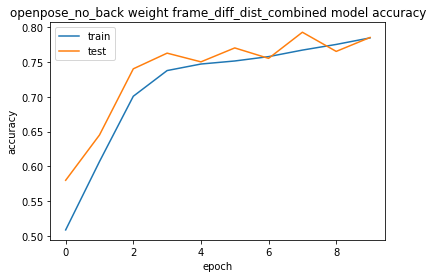

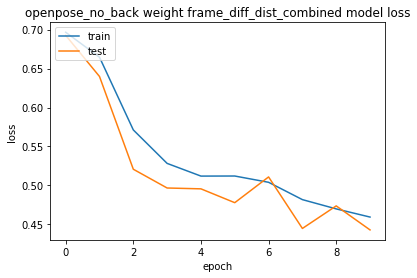

In [13]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f"openpose_{'' if BACKGROUND else 'no_'}back weight {FRAME_FUNC} model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f"openpose_{'' if BACKGROUND else 'no_'}back weight {FRAME_FUNC} model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()